In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import joblib
import shap

# ML libraries
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_curve, auc, precision_recall_curve, average_precision_score,
                           precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

In [2]:

# Load the data
df = pd.read_csv('data/Protected_Processed.csv')


In [3]:
# Define features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
# Save processed data
X_train.to_csv('X_train_processed.csv', index=False)
X_test.to_csv('X_test_processed.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train_processed.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test_processed.csv', index=False)

In [5]:
#X_train = pd.read_csv('data/training/X_train_processed.csv')
#X_test = pd.read_csv('data/training/X_test_processed.csv')
#y_train = pd.read_csv('data/training/y_train_processed.csv')
#y_test = pd.read_csv('data/training/y_test_processed.csv')

In [6]:
weights = pd.read_csv('data/weights/fairness_weights_adjusted.csv')
sample_weights = weights.values.ravel()

In [7]:
# ### 8.1 Model Evaluation Function
print("\n8.1 Model Evaluation Function")

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name,sample_weights=None):
    """
    Comprehensive function to train, evaluate and visualize model performance.
    
    Parameters:
    -----------
    model: The machine learning model to evaluate
    X_train, y_train: Training data
    X_test, y_test: Test data
    model_name: String name of the model for reporting
    sample_weights: optional array of instance weights
    Returns:
    --------
    Dictionary of performance metrics and the trained model
    """
    # Start timer
    start_time = time.time()
    if sample_weights is not None:
        model.fit(X_train, y_train, sample_weight=sample_weights)
        weight_status = "Weighted"
    else:
        model.fit(X_train, y_train)
        weight_status = "Unweighted"
          

    # End timer
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Calculate PR AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
   # Cross-validation score with sample weights
    if sample_weights is not None:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc',
                               fit_params={'sample_weight': sample_weights})
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Print results
    print(f"Model: {model_name}")
    print(f"Training Time: {train_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Cross-validation ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Classification Report:")
    print(f"  Precision (Class 1): {report['1']['precision']:.4f}")
    print(f"  Recall (Class 1): {report['1']['recall']:.4f}")
    print(f"  F1-score (Class 1): {report['1']['f1-score']:.4f}")
    print("\n")
    
    # Confusion matrix visualization
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
   # plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ROC curve visualization
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    #plt.savefig(f'roc_curve_{model_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Store results for comparison
    result = {
        'Model': model_name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'F1-Score': report['1']['f1-score'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'CV ROC AUC': cv_scores.mean(),
        'Training Time': train_time
    }
    
    return result, model


8.1 Model Evaluation Function


In [8]:
# ### 8.2 Training and Comparing Multiple Models
print("\n8.2 Training and Comparing Multiple Models")

# Define models to evaluate
models = [
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (GradientBoostingClassifier(n_estimators= 100, random_state=42), "Gradient Boosting"),
   
    (LGBMClassifier(n_estimators=100, random_state=42), "LightGBM"),
     (XGBClassifier(n_estimators=100, random_state=42), "XGBoost")
]


trained_models = {}


8.2 Training and Comparing Multiple Models


In [9]:
# Store results for comparison
unweighted_results = []
weighted_results = []

In [10]:
print(unweighted_results)
print(weighted_results)
print(trained_models)

[]
[]
{}



Training and evaluating Decision Tree...
Model: Decision Tree
Training Time: 1.32 seconds
Accuracy: 0.7191
ROC AUC: 0.5902
PR AUC: 0.8222
Cross-validation ROC AUC: 0.5927 ± 0.0014
Classification Report:
  Precision (Class 1): 0.8290
  Recall (Class 1): 0.8124
  F1-score (Class 1): 0.8206




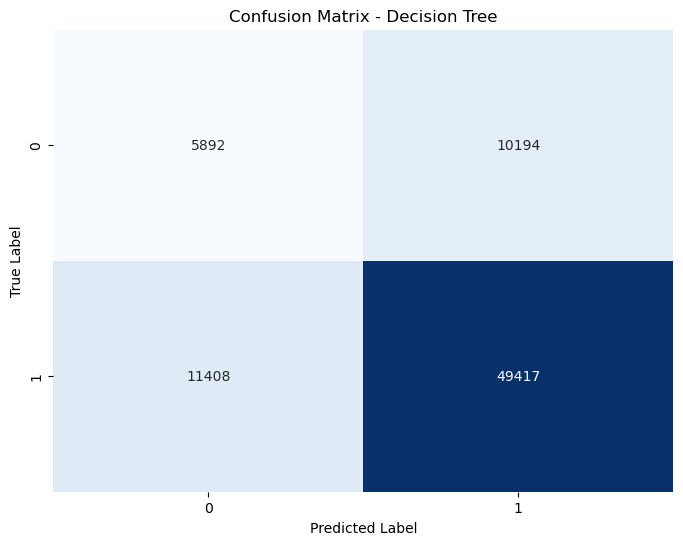

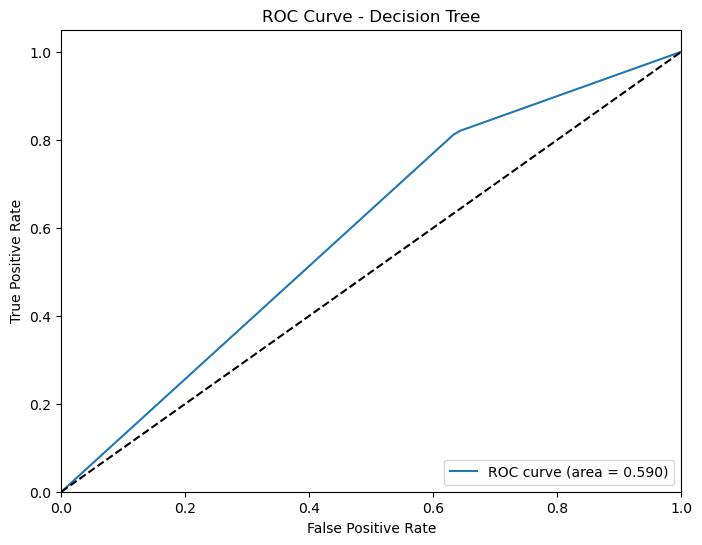


Training and evaluating Random Forest...
Model: Random Forest
Training Time: 19.66 seconds
Accuracy: 0.7874
ROC AUC: 0.7030
PR AUC: 0.8839
Cross-validation ROC AUC: 0.7042 ± 0.0028
Classification Report:
  Precision (Class 1): 0.8316
  Recall (Class 1): 0.9169
  F1-score (Class 1): 0.8722




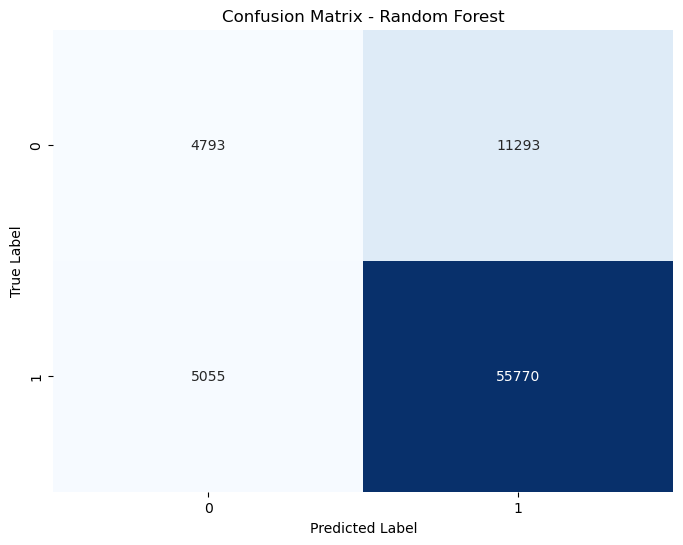

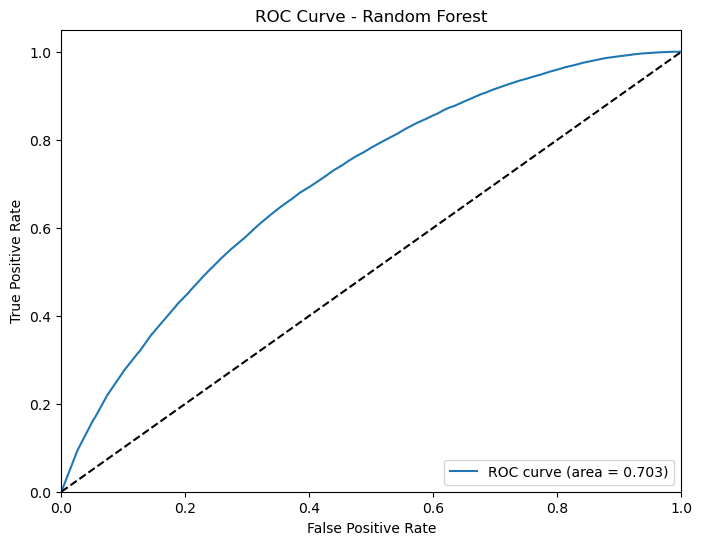


Training and evaluating Gradient Boosting...


In [ ]:
# Evaluate each model
for model, name in models:
    print(f"\nTraining and evaluating {name}...")
    result, trained_model = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    unweighted_results.append(result)
    trained_models[name] = trained_model
    
unweighted_results_df = pd.DataFrame(unweighted_results)

In [ ]:
# Evaluate each model with weights
print("\nTraining and evaluating models WITH weights...")
for model_class, name in models:
    print(f"\nTraining and evaluating {name} (Weighted)...")
    model = model_class  # Create a new instance
    result, trained_model = evaluate_model(model, X_train, y_train, X_test, y_test, name, sample_weights=sample_weights)
    weighted_results.append(result)
    trained_models[f"{name} (Weighted)"] = trained_model

# Create DataFrame for model comparison
weighted_results_df = pd.DataFrame(weighted_results)


Combined Model Performance Comparison (sorted by ROC AUC):


,Model,Accuracy,ROC AUC,PR AUC,F1-Score,Precision,Recall,CV ROC AUC,Training Time,Weight
3,LightGBM,0.813070,0.752402,0.908937,0.891789,0.822394,0.973975,0.752671,1.246650,Unweighted
4,XGBoost,0.814565,0.750910,0.907357,0.892191,0.825775,0.970226,0.750323,0.760365,Unweighted
8,LightGBM,0.694231,0.744585,0.905654,0.784913,0.884523,0.705467,0.746368,1.010335,Weighted
2,Gradient Boosting,0.809676,0.742534,0.905107,0.890400,0.817511,0.977559,0.743769,20.339365,Unweighted
9,XGBoost,0.703176,0.742325,0.903406,0.793964,0.880142,0.723157,0.742532,1.203485,Weighted
7,Gradient Boosting,0.668942,0.735378,0.902236,0.761136,0.886304,0.666946,0.737660,18.118239,Weighted
1,Random Forest,0.787443,0.703045,0.883897,0.872169,0.831606,0.916893,0.704205,22.274064,Unweighted
6,Random Forest,0.786962,0.702494,0.883819,0.872149,0.830007,0.918800,0.702321,20.971754,Weighted
5,Decision Tree,0.723473,0.590578,0.822372,0.824191,0.828836,0.819597,0.588162,1.337400,Weighted
0,Decision Tree,0.719130,0.590173,0.822248,0.820635,0.828991,0.812446,0.592680,1.360675,Unweighted


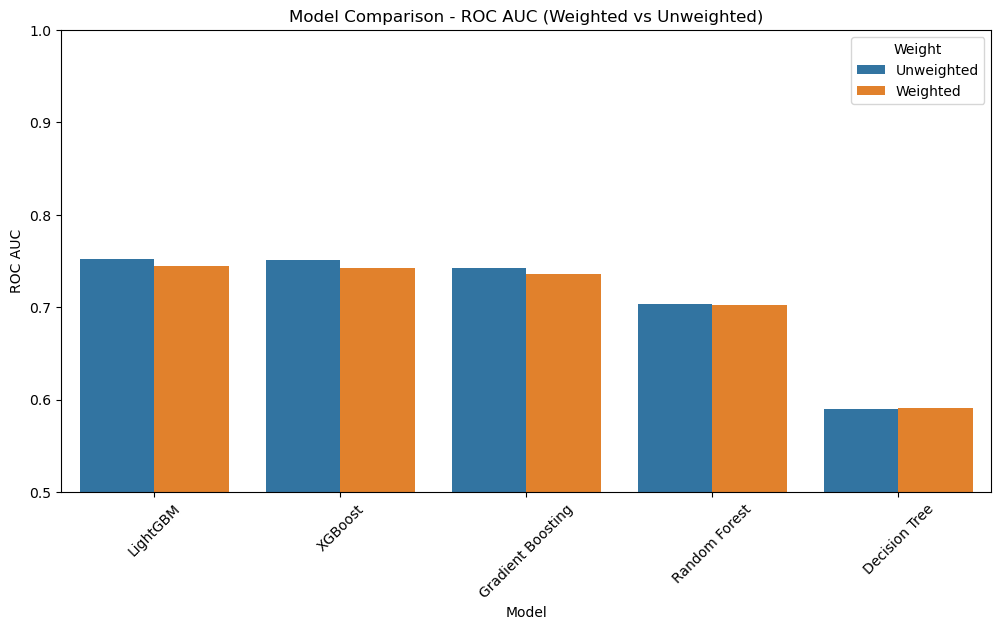

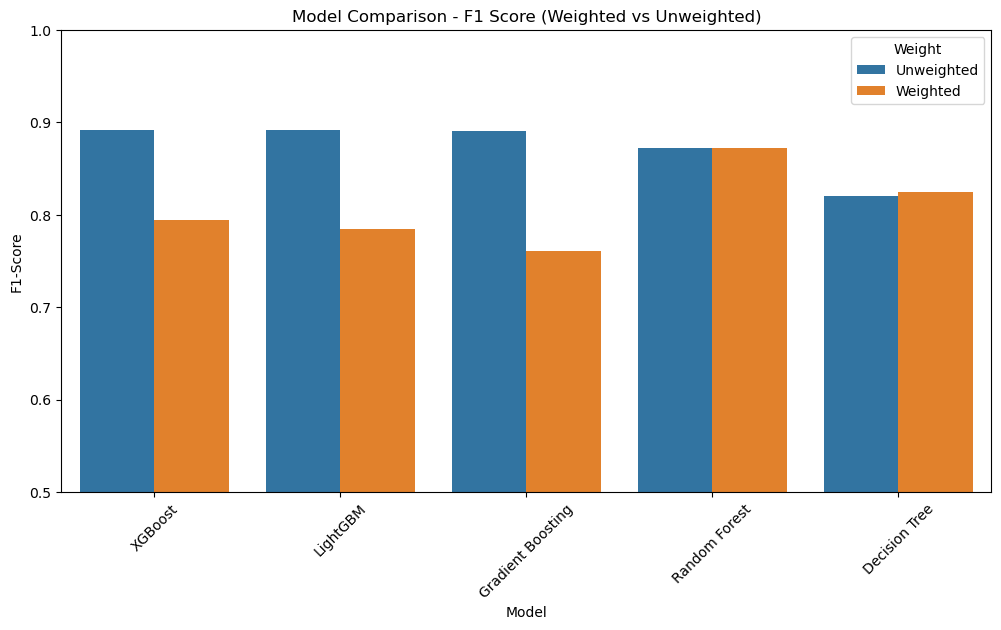

In [56]:
# Add a column to indicate weighting
unweighted_results_df['Weight'] = 'Unweighted'
weighted_results_df['Weight'] = 'Weighted'

# Combine the two DataFrames for comparison
combined_df = pd.concat([unweighted_results_df, weighted_results_df], ignore_index=True)

# Display the combined DataFrame sorted by ROC AUC
print("\nCombined Model Performance Comparison (sorted by ROC AUC):")
display(combined_df.sort_values('ROC AUC', ascending=False))

# Plot model comparison - ROC AUC with weighting as hue
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='ROC AUC', hue='Weight', data=combined_df.sort_values('ROC AUC', ascending=False))
plt.title('Model Comparison - ROC AUC (Weighted vs Unweighted)')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)  
plt.show()

# Plot model comparison - F1 Score with weighting as hue
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1-Score', hue='Weight', data=combined_df.sort_values('F1-Score', ascending=False))
plt.title('Model Comparison - F1 Score (Weighted vs Unweighted)')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)  
plt.show()
